# Linear Discriminant Analysis

In [43]:
# import necessary modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [44]:
# import cleaned data frame
df_cleaned = pd.read_csv('cleaned_data/Cleaned Data.csv', index_col=[0])
sig = df_cleaned['Signal'] # for plotting histogram

Text(0.5, 1.0, 'Class Distribution')

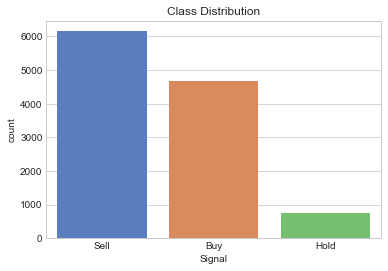

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(df_cleaned['Signal'],palette='muted')
plt.title('Class Distribution')
#plt.savefig('my_picture.png',dpi=200)

## Factorize signal

In [3]:
# code by Christian
SignalFac = []

for string in df_cleaned['Signal']:
    if string == 'Sell':
        SignalFac.append(0)
    elif string == 'Hold':
        SignalFac.append(1)    
    else:
        SignalFac.append(2)

In [4]:
df_cleaned['SignalFac'] = SignalFac
df_cleaned.drop('Signal', axis=1, inplace=True)

In [5]:
X = df_cleaned.drop('SignalFac',axis=1)
y = df_cleaned['SignalFac']

## Part 1: Split data in training and test split

In [6]:
# get training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0, stratify=y)

## Part 2: Setup for 5-fold CV on training set

In [7]:
# Create k-Fold CV
kFold = StratifiedKFold(n_splits = 5)

## Feed LDA with training data

In [8]:
# create LDA object and run classifier
lda = LDA(solver="lsqr")
lda = lda.fit(X_train, y_train)

In [9]:
# performance on training set
print('score: {0:.4f}'.format(lda.score(X_train, y_train)))
print('error-rate: {0:.4f}'.format(1-lda.score(X_train, y_train)))

score: 0.5492
error-rate: 0.4508


In [10]:
# performance on test set
y_pred = lda.predict(X_test)
print('score test set: {0:.4f}'.format(accuracy_score(y_test, y_pred)))

score test set: 0.5440


In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.94      0.69      1846
           1       0.09      0.01      0.02       224
           2       0.55      0.10      0.17      1404

    accuracy                           0.54      3474
   macro avg       0.40      0.35      0.29      3474
weighted avg       0.52      0.54      0.44      3474



In [12]:
from sklearn import metrics
print('Confusion matrix: \n', 
      metrics.confusion_matrix(y_test, y_pred))

Confusion matrix: 
 [[1742   10   94]
 [ 197    2   25]
 [1248   10  146]]


## Feed LDA with standardized training data

In [13]:
# standardize features
# Apply StandardScaler on continuous columns only (our data is continuous)
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train) # fit & transform
X_test_std = stdsc.transform(X_test) # ONLY transform

In [14]:
# create LDA object and run classifier on standardized features
lda_std = LDA(solver="lsqr")
lda_std = lda_std.fit(X_train_std, y_train)

In [15]:
# performance on standardized training set
print('score: {0:.4f}'.format(lda_std.score(X_train_std, y_train)))
print('error-rate: {0:.4f}'.format(1-lda_std.score(X_train_std, y_train)))

score: 0.5763
error-rate: 0.4237


In [16]:
# performance on standardized test set
y_pred_std = lda_std.predict(X_test_std)
print('score standardized test set: {0:.4f}'.format(accuracy_score(y_test, y_pred_std)))

score standardized test set: 0.5504


## Feed LDA with balanaced training data

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

Text(0.5, 1.0, 'Class Distribution')

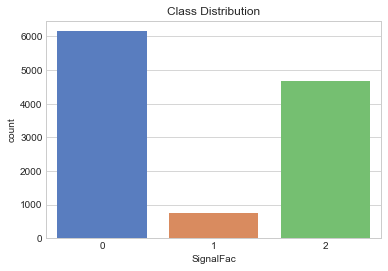

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(y,palette='muted')
plt.title('Class Distribution')
#plt.savefig('my_picture.png',dpi=200)

In [25]:
from sklearn.utils import resample

# upsampling for balanced data set
X_upsampled, y_upsampled = resample(X[y==1], y[y==1],
                                   replace = True,
                                   n_samples = X[y==0].shape[0],
                                   random_state=1)
X_upsampled_2, y_upsampled_2 = resample(X[y==2], y[y==2],
                                   replace = True,
                                   n_samples = X[y==0].shape[0],
                                   random_state=1)

# combining the different classifications together
X_bal = np.vstack((X[y==0], X_upsampled, X_upsampled_2))
y_bal = np.hstack((y[y==0], y_upsampled, y_upsampled_2))

# check how large the data is
y_bal.shape

(18459,)

In [26]:
# split the balanced data set 
X_train_bal, X_test_bal, y_train_bal, y_test_bal = \
    train_test_split(X_bal, y_bal, 
                     test_size = 0.3, 
                     random_state = 0, 
                     stratify = y_bal)

# standardize the balanced data set
X_train_bal_std = stdsc.fit_transform(X_train_bal)
X_test_bal_std =stdsc.transform(X_test_bal)


In [27]:
from sklearn import metrics
lda_bal = LDA(solver="lsqr")
lda_bal.fit(X_train_bal_std, y_train_bal)

y_pred_bal = lda_bal.predict(X_test_bal_std)
print(metrics.classification_report(y_test_bal, y_pred_bal))
print(metrics.confusion_matrix(y_test_bal, y_pred_bal))
print("Test score : {:.2f}".format(lda_bal.score(X_test_bal_std, y_test_bal)))

              precision    recall  f1-score   support

           0       0.46      0.42      0.44      1846
           1       0.46      0.56      0.50      1846
           2       0.42      0.36      0.39      1846

    accuracy                           0.45      5538
   macro avg       0.44      0.45      0.44      5538
weighted avg       0.44      0.45      0.44      5538

[[ 773  600  473]
 [ 369 1028  449]
 [ 553  627  666]]
Test score : 0.45


# Quadratic Discriminant Analysis

## Feed QDA model

In [27]:
# Run QDA on training data
qda = QDA().fit(X_train, y_train)
print(qda.score(X_test, y_test))

0.1971790443293034


C:\Users\Lony\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [24]:
# Predict classes for qda
y_pred_qda = qda.predict(X_test)

# Print performance metrics
print(metrics.confusion_matrix(y_test, y_pred_qda))
print(metrics.classification_report(y_test, y_pred_qda))

[[ 194 1175  477]
 [  13  162   49]
 [ 138  937  329]]
0.1971790443293034
              precision    recall  f1-score   support

           0       0.56      0.11      0.18      1846
           1       0.07      0.72      0.13       224
           2       0.38      0.23      0.29      1404

    accuracy                           0.20      3474
   macro avg       0.34      0.35      0.20      3474
weighted avg       0.46      0.20      0.22      3474

